### PROYECTO: PREDICCIÓN DE LA TASA DE DESEMPLEO EN COLOMBIA: UN ESTUDIO COMPARATIVO DE MODELOS HÍBRIDOS Y AVANZADOS.

### MODELO XGBOOST

#### Elaborado por : Yairo Jose Oviedo Salazar

In [2]:
# Cargar librerias

!pip install xgboost
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb

# Función para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Establecer la semilla aleatoria
seed = 42
np.random.seed(seed)

# Leer el archivo CSV limpio
file_path = 'TD_BUSQUEDAS_GOOGLE.csv'
df_cleaned = pd.read_csv(file_path, sep=";", parse_dates=['Mes'], index_col='Mes')

# Rango de fechas a filtrar
fecha_inicio = '2014-01-01'
fecha_fin = '2024-03-31'

# Filtrar el DataFrame para el rango de fechas
df_cleaned = df_cleaned.loc[fecha_inicio:fecha_fin]

# Convertir las columnas de tipo object a float, si es necesario
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object':
        df_cleaned[col] = df_cleaned[col].str.replace(',', '.').astype(float)

# Separar las variables predictoras y la variable objetivo
X = df_cleaned.drop(columns=['Tasa Desempleo'])
y = df_cleaned['Tasa Desempleo']

# Estandarizar las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA para obtener las 11 componentes principales
pca = PCA(n_components=11, random_state=seed)
X_pca = pca.fit_transform(X_scaled)

# Crear un DataFrame con las componentes principales
pca_columns = [f'PC{i+1}' for i in range(11)]
df_pca = pd.DataFrame(data=X_pca, columns=pca_columns, index=df_cleaned.index)
df_pca['Tasa Desempleo'] = y.values

# Verificar que no haya valores NaN o infinitos en los datos
df_pca.replace([np.inf, -np.inf], np.nan, inplace=True)
df_pca.dropna(inplace=True)

# Dividir el dataset en conjuntos de entrenamiento y prueba secuencialmente
n_train = int(len(df_pca) * 0.95)
X_train, X_test = df_pca.drop(columns=['Tasa Desempleo']).iloc[:n_train], df_pca.drop(columns=['Tasa Desempleo']).iloc[n_train:]
y_train, y_test = df_pca['Tasa Desempleo'].iloc[:n_train], df_pca['Tasa Desempleo'].iloc[n_train:]

# Mostrar el tamaño de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

# Definir los parámetros para Grid Search
param_grid_xgb = {
    'n_estimators': [50, 100, 300],
    'learning_rate': [0.001, 0.01, 0.5],
    'max_depth': [2, 3, 4],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'alpha': [0, 1, 1.5],
    'lambda': [1, 1.5, 2]
}

# Utilizar TimeSeriesSplit para validación cruzada
tscv = TimeSeriesSplit(n_splits=5)

# Definir el modelo XGBoost
xgb_model = xgb.XGBRegressor(random_state=seed, objective='reg:squarederror')

# Configuración de GridSearchCV con el callback para early stopping
grid_search_xgb = GridSearchCV(
    xgb_model, 
    param_grid_xgb, 
    cv=tscv, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    refit=True
)

# Entrenamiento con GridSearchCV y el callback
grid_search_xgb.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)],
    callbacks=[xgb.callback.EarlyStopping(rounds=10)]
)

best_xgb = grid_search_xgb.best_estimator_

# Predicciones
y_train_pred_xgb = best_xgb.predict(X_train)
y_test_pred_xgb = best_xgb.predict(X_test)

# Evaluar el modelo XGBoost
rmse_xgb_train = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
mae_xgb_train = mean_absolute_error(y_train, y_train_pred_xgb)
mape_xgb_train = mean_absolute_percentage_error(y_train, y_train_pred_xgb)
r2_xgb_train = r2_score(y_train, y_train_pred_xgb)

rmse_xgb_test = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
mae_xgb_test = mean_absolute_error(y_test, y_test_pred_xgb)
mape_xgb_test = mean_absolute_percentage_error(y_test, y_test_pred_xgb)
r2_xgb_test = r2_score(y_test, y_test_pred_xgb)

print(f'XGBoost Model - Best Params: {grid_search_xgb.best_params_}')
print(f'Training - RMSE: {rmse_xgb_train}, MAE: {mae_xgb_train}, MAPE: {mape_xgb_train}, R^2: {r2_xgb_train}')
print(f'Test - RMSE: {rmse_xgb_test}, MAE: {mae_xgb_test}, MAPE: {mape_xgb_test}, R^2: {r2_xgb_test}')




Tamaño del conjunto de entrenamiento: (116, 11)
Tamaño del conjunto de prueba: (7, 11)
[0]	validation_0-rmse:0.96699
[1]	validation_0-rmse:0.80007
[2]	validation_0-rmse:0.77201
[3]	validation_0-rmse:0.72735
[4]	validation_0-rmse:0.72852
[5]	validation_0-rmse:0.81844
[6]	validation_0-rmse:0.83095
[7]	validation_0-rmse:0.89075
[8]	validation_0-rmse:0.88455
[9]	validation_0-rmse:0.88885
[10]	validation_0-rmse:0.86306
[11]	validation_0-rmse:0.87182
[12]	validation_0-rmse:0.84863
XGBoost Model - Best Params: {'alpha': 0, 'colsample_bytree': 0.8, 'lambda': 1, 'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.8}
Training - RMSE: 0.7037627063262543, MAE: 0.47619355958083576, MAPE: 4.290340395347663, R^2: 0.9351167841678398
Test - RMSE: 0.7273511476786322, MAE: 0.5899621146065847, MAPE: 5.784703732400054, R^2: 0.6982721886813508


C:\Users\yairo\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


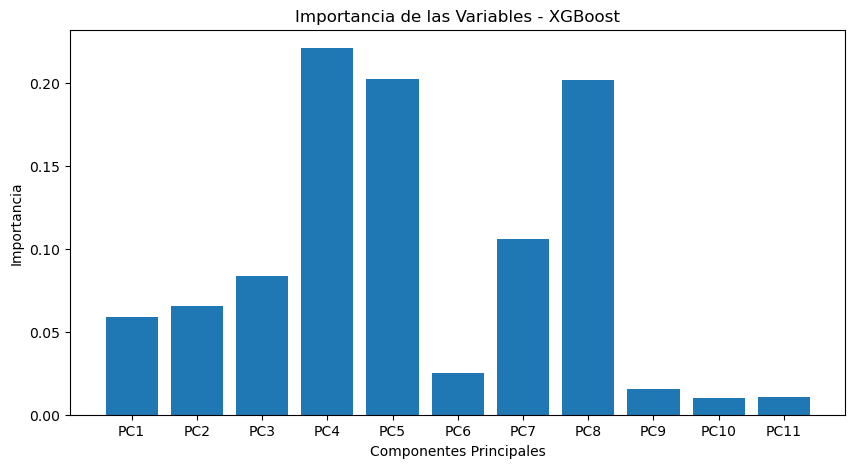

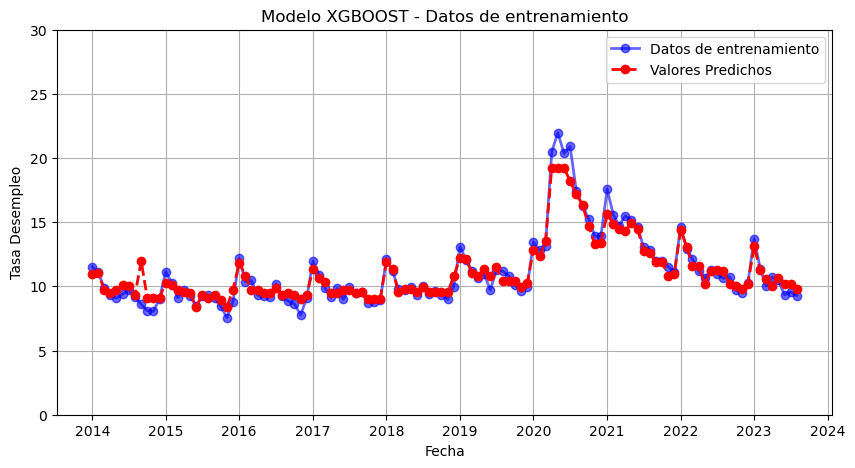

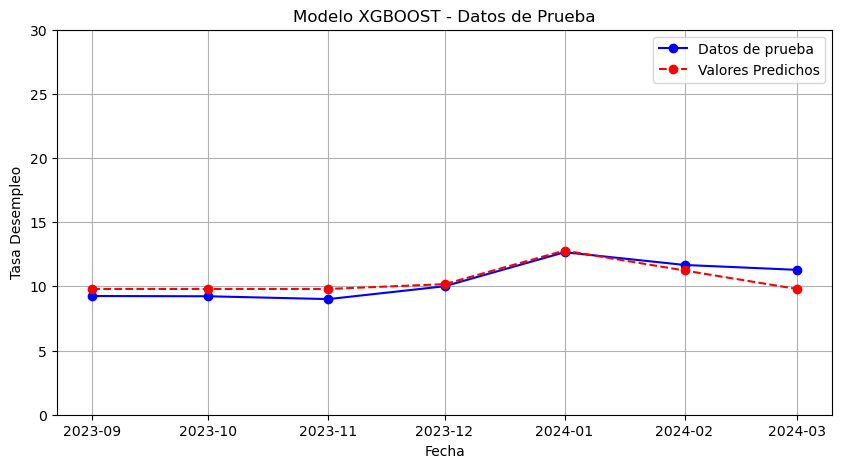

In [4]:
# Graficar la importancia de las variables
importance = best_xgb.feature_importances_
plt.figure(figsize=(10, 5))
plt.bar(pca_columns, importance)
plt.title('Importancia de las Variables - XGBoost')
plt.xlabel('Componentes Principales')
plt.ylabel('Importancia')
plt.show()
# Graficar los resultados de XGBoost - Entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(X_train.index, y_train.values, label='Datos de entrenamiento', alpha=0.6, linewidth=2, marker='o', color='blue', linestyle='-')
plt.plot(X_train.index, y_train_pred_xgb, label='Valores Predichos', linewidth=2, marker='o', color='red', linestyle='--')
plt.ylim(0, 30)  # Ajustar el límite del eje y
plt.title('Modelo XGBOOST - Datos de entrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Tasa Desempleo')
plt.legend()
plt.grid(True)
plt.show()

# Graficar los resultados de XGBoost - Prueba
plt.figure(figsize=(10, 5))
plt.plot(X_test.index, y_test.values, label='Datos de prueba', marker='o', color='blue', linestyle='-')
plt.plot(X_test.index, y_test_pred_xgb, label='Valores Predichos', marker='o', color='red', linestyle='--')
plt.ylim(0, 30)  # Ajustar el límite del eje y
plt.title('Modelo XGBOOST - Datos de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Tasa Desempleo')
plt.legend()
plt.grid(True)

In [5]:
# Leer nuevamente el archivo CSV para obtener los dos nuevos datos
df_new_data = pd.read_csv(file_path, sep=";", parse_dates=['Mes'], index_col='Mes')

# Seleccionar los últimos dos registros diferentes de la tasa de desempleo
X_new = df_new_data.drop(columns=['Tasa Desempleo']).iloc[-2:]

# Convertir las columnas de tipo object a float, si es necesario
for col in X_new.columns:
    if X_new[col].dtype == 'object':
        X_new[col] = X_new[col].str.replace(',', '.').astype(float)

# Estandarizar y aplicar PCA a los nuevos datos
X_new_scaled = scaler.transform(X_new)
X_new_pca = pca.transform(X_new_scaled)

# Realizar la predicción de los dos nuevos datos
future_predictions = best_xgb.predict(X_new_pca)

# Mostrar las predicciones de los dos nuevos datos
print("Predicciones para los dos nuevos datos de la serie:")
for i, pred in enumerate(future_predictions, 1):
    print(f"Predicción {i}: {pred}")

Predicciones para los dos nuevos datos de la serie:
Predicción 1: 9.967283248901367
Predicción 2: 10.068584442138672


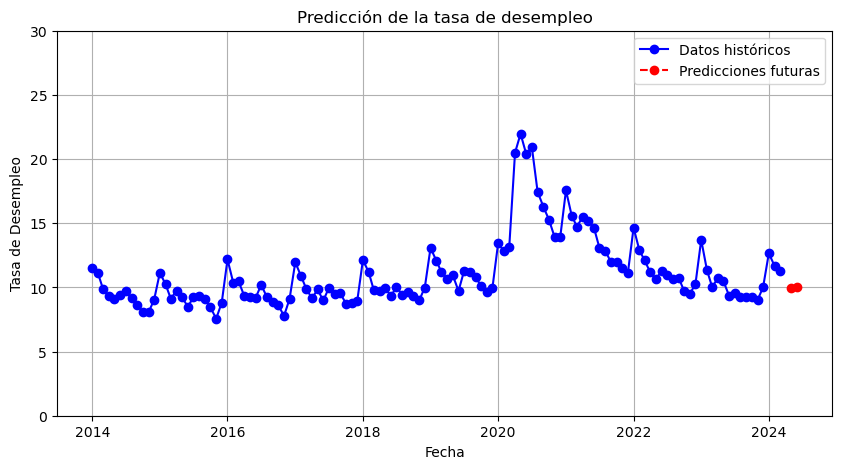

In [6]:
# Graficar los datos históricos y los nuevos registros conectados
plt.figure(figsize=(10, 5))
plt.plot(df_pca.index, y, label='Datos históricos', color='blue', marker='o', linestyle='-')
plt.plot(pd.date_range(start=df_pca.index[-1], periods=3, freq='M')[1:], future_predictions, label='Predicciones futuras', color='red', marker='o', linestyle='--')
plt.ylim(0, 30)  # Ajustar el límite del eje y
plt.title('Predicción de la tasa de desempleo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Desempleo')
plt.legend()
plt.grid(True)
plt.show()
